## Model Training: LSTM

In [12]:
import gc
import sys
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from scipy import signal
from scipy.signal import resample, hilbert
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

In [24]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_10000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_10000.feather')
metadata = metadata.reset_index()

In [5]:
raw_signals.shape

(10000, 6000, 3)

In [11]:
raw_signals[0][:,2]

array([-0.        ,  0.00024294,  0.00068383, ...,  0.00162756,
        0.00026638,  0.        ], dtype=float32)

In [13]:
def hilbert_transform_rolling_avg(raw_signal):
    sos = signal.butter(4, (1,49.9), 'bandpass', fs=100, output='sos') # filter signal from 1-50 Hz, 4th order filter
    filtered = signal.sosfilt(sos, raw_signal[:,2]) # use only z-axis signal component
    analytic_signal = hilbert(filtered) # apply hilbert transform to get signal envelope
    amplitude_envelope = np.abs(analytic_signal) # get only positive envelope
    env_series = pd.Series(amplitude_envelope) # convert to a series to be compatible with pd.Series rolling mean calc
    rolling_obj = env_series.rolling(200) # 2-second rolling mean (100 Hz * 2 sec = 200 samples)
    rolling_average = rolling_obj.mean()
    rolling_average_demeaned = rolling_average[199:] - np.mean(rolling_average[199:])
    rolling_average_padded = np.pad(rolling_average_demeaned,(199,0),'constant',constant_values=(list(rolling_average_demeaned)[0])) # pad with zeros to remove nans created by rolling mean
    resamp = signal.resample(rolling_average_padded, 300) # resample signal from 6000 samples to 300 to reduce size
    return resamp

In [14]:
signal_envelopes = np.array([hilbert_transform_rolling_avg(raw_signal) for raw_signal in raw_signals])

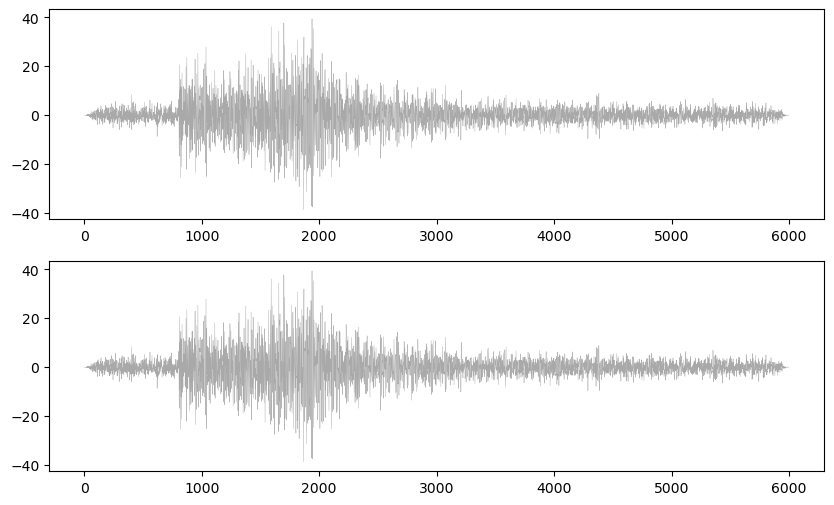

In [23]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,6))
ax1.plot(raw_signals[0][:,2], color='darkgrey', linewidth=0.3)
ax2.plot(raw_signals[0][:,2], color='darkgrey', linewidth=0.3)